In [ ]:
!pip install google-cloud-vision
from google.cloud import vision
import io
import os

# Initialize the client once, to be used by the recursive function
client = vision.ImageAnnotatorClient()

# Function to recursively process images and detect labels
def detect_labels_in_directory(directory):
    # List to keep track of all the labels detected
    all_labels = []

    # Recursive function to process each file and subdirectory
    def process_directory(subdir):
        for entry in os.scandir(subdir):
            if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Processing image: {entry.path}")
                labels = detect_labels(entry.path)
                all_labels.append((entry.path, labels))
            elif entry.is_dir():
                process_directory(entry.path)

    # Helper function to detect labels for a single image
    def detect_labels(image_path):
        with io.open(image_path, 'rb') as image_file:
            content = image_file.read()
        image = vision.Image(content=content)
        response = client.label_detection(image=image)
        labels = response.label_annotations
        return [label.description for label in labels]

    # Start processing from the root directory
    process_directory(directory)

    return all_labels

# Path to the directory where images have been unzipped
root_directory = '/content/images'

labels_detected = detect_labels_in_directory(root_directory)


for image_path, labels in labels_detected:
    print(f"Labels for {image_path}: {labels}")


In [ ]:
!pip install gensim
!pip install nltk


In [6]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Extract just the labels for LDA
documents = [labels for image_path, labels in labels_detected]

# Tokenize and clean up the text
texts = [[word for word in document if word not in stopwords.words('english')]
         for document in documents]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Create a corpus from the dictionary and tokenized documents
corpus = [dictionary.doc2bow(text) for text in texts]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


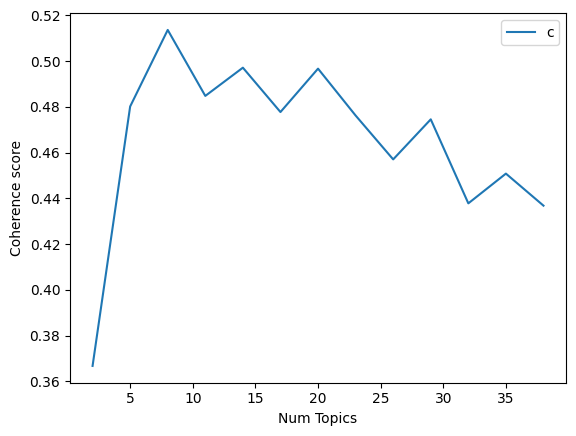

Num Topics = 2  has Coherence Value of 0.3668
Num Topics = 5  has Coherence Value of 0.4802
Num Topics = 8  has Coherence Value of 0.5137
Num Topics = 11  has Coherence Value of 0.4848
Num Topics = 14  has Coherence Value of 0.4972
Num Topics = 17  has Coherence Value of 0.4778
Num Topics = 20  has Coherence Value of 0.4968
Num Topics = 23  has Coherence Value of 0.4763
Num Topics = 26  has Coherence Value of 0.4571
Num Topics = 29  has Coherence Value of 0.4746
Num Topics = 32  has Coherence Value of 0.4379
Num Topics = 35  has Coherence Value of 0.4509
Num Topics = 38  has Coherence Value of 0.4368


In [7]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, limit=40)

# Show graph
import matplotlib.pyplot as plt

limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [8]:
# Select the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
model_topics = optimal_model.show_topics(formatted=False)

# Print the Keyword in the 10 topics
optimal_model.print_topics(num_words=25)


[(0,
  '0.038*"Smile" + 0.036*"Sleeve" + 0.034*"Flash photography" + 0.029*"Formal wear" + 0.026*"Forehead" + 0.025*"Hairstyle" + 0.023*"Fashion design" + 0.023*"Eyebrow" + 0.022*"Eyelash" + 0.020*"Hair" + 0.020*"Gesture" + 0.019*"Blazer" + 0.017*"Happy" + 0.017*"Facial expression" + 0.017*"Neck" + 0.017*"Human" + 0.017*"Outerwear" + 0.017*"Chin" + 0.015*"Fashion" + 0.014*"Event" + 0.014*"Photograph" + 0.014*"Lip" + 0.013*"Face" + 0.012*"Jaw" + 0.012*"Tie"'),
 (1,
  '0.038*"Eyewear" + 0.034*"Flash photography" + 0.034*"People in nature" + 0.034*"Sunglasses" + 0.031*"Vision care" + 0.031*"Happy" + 0.030*"Sky" + 0.029*"Plant" + 0.026*"Smile" + 0.025*"Glasses" + 0.023*"Sleeve" + 0.020*"Goggles" + 0.019*"Waist" + 0.017*"Fun" + 0.016*"Fashion" + 0.015*"Fashion design" + 0.014*"Gesture" + 0.014*"Tree" + 0.014*"Leisure" + 0.013*"Thigh" + 0.012*"Neck" + 0.011*"Leg" + 0.011*"Shoulder" + 0.011*"Event" + 0.011*"Pink"'),
 (2,
  '0.051*"Gesture" + 0.043*"Happy" + 0.040*"Smile" + 0.036*"T-shirt" + 0

In [9]:
# Assigns the topics to the documents in corpus
lda_corpus = optimal_model[corpus]

# Find the dominant topic in each document
from collections import Counter
image_topics = [max(doc, key=lambda x: x[1])[0] for doc in lda_corpus]
topic_count = Counter(image_topics)

print(topic_count)


Counter({0: 905, 5: 115, 2: 108, 4: 100, 1: 98, 7: 86, 6: 72, 3: 38})


In [ ]:
!pip install pyLDAvis

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)
vis


In [12]:
import pandas as pd
# Create a dictionary to map the topic number to the topic name
topic_names = {
    0: "Formal Events and Fashion",
    1: "Outdoor Leisure and Vision",
    2: "Casual Wear and Happy Moments",
    3: "Musical Events and Performance",
    4: "Sports and Athletic Wear",
    5: "Digital Content and Branding",
    6: "Nature and Outdoors",
    7: "Food and Cuisine"
}

def create_topic_weights_df(model, corpus, dictionary):
    # Initiate our list of topics
    topic_weights = []

    # Get the main topic for each document
    for doc_topics in model[corpus]:
        doc_topic_weights = {topic_names[topic_id]: weight for topic_id, weight in doc_topics}
        topic_weights.append(doc_topic_weights)

    return pd.DataFrame(topic_weights)

# Create the topic weights DataFrame
df_topic_weights = create_topic_weights_df(optimal_model, corpus, dictionary)


df_topic_weights['image_filename'] = [os.path.basename(path) for path, _ in labels_detected]

df_topic_weights.head()  # Display the first few rows of the DataFrame


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Formal Events and Fashion,Outdoor Leisure and Vision,Casual Wear and Happy Moments,Musical Events and Performance,Sports and Athletic Wear,Digital Content and Branding,Nature and Outdoors,Food and Cuisine,image_filename
0,0.011369,0.011384,0.920296,0.011383,0.011365,0.011413,0.011402,0.011388,2023-01-25_17-21-45_UTC.jpg
1,0.193010,0.011367,0.011367,0.011367,0.011367,0.011367,0.011367,0.738788,2023-03-21_19-01-00_UTC.jpg
2,0.197294,0.011375,0.734488,0.011370,0.011369,0.011367,0.011371,0.011364,2013-07-23_19-48-45_UTC.jpg
3,0.830944,0.011370,0.011377,0.011375,0.011367,0.100836,0.011366,0.011365,2023-03-15_16-00-27_UTC.jpg
4,0.011364,0.011364,0.011365,0.011370,0.011367,0.011365,0.920441,0.011364,2023-01-26_04-09-52_UTC_1.jpg


In [29]:
df_topic_weights.columns

Index(['Formal Events and Fashion', 'Outdoor Leisure and Vision',
       'Casual Wear and Happy Moments', 'Musical Events and Performance',
       'Sports and Athletic Wear', 'Digital Content and Branding',
       'Nature and Outdoors', 'Food and Cuisine', 'image_filename'],
      dtype='object')

In [47]:

df_topic_weights['post_foldername'] = [os.path.basename(os.path.dirname(path)) for path, _ in labels_detected]

df_topic_weights.head()  # Display the first




,Formal Events and Fashion,Outdoor Leisure and Vision,Casual Wear and Happy Moments,Musical Events and Performance,Sports and Athletic Wear,Digital Content and Branding,Nature and Outdoors,Food and Cuisine,image_filename,post_foldername
0,0.011369,0.011384,0.920296,0.011383,0.011365,0.011413,0.011402,0.011388,2023-01-25_17-21-45_UTC.jpg,drwaynedyer_683926_3023650967341437021_12701_129
1,0.193010,0.011367,0.011367,0.011367,0.011367,0.011367,0.011367,0.738788,2023-03-21_19-01-00_UTC.jpg,food52_3599596_3063563568926568942_13224_80
2,0.197294,0.011375,0.734488,0.011370,0.011369,0.011367,0.011371,0.011364,2013-07-23_19-48-45_UTC.jpg,eventplannerlife_181_506578844098966639_20_4
3,0.830944,0.011370,0.011377,0.011375,0.011367,0.100836,0.011366,0.011365,2023-03-15_16-00-27_UTC.jpg,hbomax_3056324_3059124062736269113_3896_23
4,0.011364,0.011364,0.011365,0.011370,0.011367,0.011365,0.920441,0.011364,2023-01-26_04-09-52_UTC_1.jpg,hardikpandya93_25298326_3023977180106450266_56...
5,0.011367,0.011368,0.105494,0.011373,0.011370,0.011367,0.826294,0.011367,2023-01-26_04-09-52_UTC_2.jpg,hardikpandya93_25298326_3023977180106450266_56...
6,0.031250,0.031250,0.031257,0.031271,0.031250,0.781219,0.031250,0.031252,2023-03-01_20-04-36_UTC.jpg,drwaynedyer_683926_3049100086597128607_10205_94
7,0.408344,0.415152,0.011398,0.011373,0.011374,0.119623,0.011372,0.011366,2023-03-28_12-00-21_UTC.jpg,food52_3599596_3068425271174740191_2166_80
8,0.576192,0.011367,0.011379,0.181240,0.011370,0.185723,0.011365,0.011364,2023-03-02_13-08-07_UTC.jpg,grantcardone_4290201_3049615239923090653_1928_304
9,0.011367,0.011367,0.011367,0.011367,0.011367,0.101332,0.011367,0.830467,2022-06-09_02-17-18_UTC.jpg,halfbakedharvest_5247243_2856497322898174565_6...


In [51]:
df_topic_weights.shape

(1522, 10)

In [46]:
df_topic_weights.shape

(1522, 10)

In [28]:
import lzma
import json
import pandas as pd
import os

# Function to read .json.xz files and extract number of comments
def extract_comments_from_jsonxz(folder_path):
    comments_data = []

    # Iterate over all subfolders and files
    for subdir, dirs, files in os.walk(folder_path):
        for filename in files:
            # Check for the .json.xz file extension and ignore macOS metadata files
            if filename.endswith(".json.xz") and not filename.startswith("._"):
                file_path = os.path.join(subdir, filename)

                # Attempt to open the lzma compressed file
                try:
                    with lzma.open(file_path, 'rt') as file:
                        # Load the JSON content
                        data = json.load(file)
                        # Extract the number of comments from the JSON data
                        num_comments = data['node']['edge_media_to_comment']['count']
                        # Store in the list with its corresponding image path
                        comments_data.append({
                            'image_path': subdir.split('/')[-1],  
                            'number_of_comments': num_comments
                        })
                except lzma.LZMAError as e:
                    print(f"An error occurred while decompressing {file_path}: {e}")
                except json.JSONDecodeError as e:
                    print(f"JSON decode error in file {file_path}: {e}")

    # Create a DataFrame from the list
    comments_df = pd.DataFrame(comments_data)

    # Sort the DataFrame by the number of comments in descending order
    sorted_comments_df = comments_df.sort_values(by='number_of_comments', ascending=False)

    return sorted_comments_df

main_folder_path = '/content/images'  

# Extract comments and sort them
df_comments_sorted = extract_comments_from_jsonxz(main_folder_path)

df_comments_sorted.head()


,image_path,number_of_comments
29,halfbakedharvest_5247243_2996407846187385570_2...,693966
216,halfbakedharvest_5247243_2990612658156456674_2...,515973
139,halfbakedharvest_5247243_2986269265263400579_1...,331474
70,halfbakedharvest_5247243_3000750743145862289_1...,239765
265,halfbakedharvest_5247243_2869549391481578933_9...,184733


In [32]:
df_comments_sorted.shape

(296, 2)

In [40]:


# Merge the DataFrames on the 'image_path' and 'image_filename' columns
df_merged = df_comments_sorted.merge(df_topic_weights, left_on='image_path', right_on='post_foldername')

# Calculate the quartiles of the number of comments for engagement
quartiles = df_merged['number_of_comments'].quantile([0.25, 0.75])
high_engagement_threshold = quartiles[0.75]
low_engagement_threshold = quartiles[0.25]

# Filter the DataFrame into high and low engagement based on the quartiles
high_engagement = df_merged[df_merged['number_of_comments'] >= high_engagement_threshold]
low_engagement = df_merged[df_merged['number_of_comments'] <= low_engagement_threshold]

# Select the topic columns for averaging (excluding 'image_filename')
topic_columns = df_topic_weights.columns[:-2]

# Get the average topic weights for the high and low engagement quartiles
high_engagement_avg_weights = high_engagement[topic_columns].mean()
low_engagement_avg_weights = low_engagement[topic_columns].mean()

# Create a table (DataFrame) to show the average topic weights for high and low engagement
results_table = pd.DataFrame({
    'Topic': topic_columns,
    'High Engagement Avg Weights': high_engagement_avg_weights.values,
    'Low Engagement Avg Weights': low_engagement_avg_weights.values
})

# Show the results table
results_table


,Topic,High Engagement Avg Weights,Low Engagement Avg Weights
0,Formal Events and Fashion,0.152796,0.130055
1,Outdoor Leisure and Vision,0.135640,0.123097
2,Casual Wear and Happy Moments,0.112544,0.153359
3,Musical Events and Performance,0.097433,0.099123
4,Sports and Athletic Wear,0.182938,0.127017
5,Digital Content and Branding,0.092226,0.162322
6,Nature and Outdoors,0.129024,0.096579
7,Food and Cuisine,0.097399,0.108449


In [52]:
df_merged.shape

(1522, 12)